In [25]:
from tensorflow.keras import Sequential
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1 

In [6]:
import os
import cv2
from tensorflow import keras
import matplotlib.pyplot as plt

In [84]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# data augmentation

batch_size=16
train_datagen=ImageDataGenerator(
    rotation_range=30,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


test_datagen=ImageDataGenerator(rescale=1./255)

# preprocessing
train_generator=train_datagen.flow_from_directory(
    r"dog_catsDataset\train",
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary'
)
test_generator=test_datagen.flow_from_directory(
    r"dog_catsDataset\valid",
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary'
)


Found 1725 images belonging to 2 classes.
Found 403 images belonging to 2 classes.


## Base model -VGG16

In [3]:
base_model=VGG16(
    weights='imagenet',
    include_top=False,  # not training the fully connected layers
    input_shape=(150,150,3)
)

In [4]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

# Hyperparameter tuning

In [90]:


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

def create_model(hp):
    model = Sequential(name='Hyperparameter-Tuning')
    model.add(base_model)
    model.add(Flatten())

    model.add(Dense(
        units=hp.Int('units', min_value=256, max_value=512, step=32),
        kernel_regularizer=l1(hp.Choice('reg', values=[0.0, 0.1, 0.001, 0.0001])),
        activation='relu'
    ))

    model.add(Dropout(hp.Choice('dp', values=[0.1, 0.0, 0.001])))
    model.add(Dense(1, activation='sigmoid'))

    optimizer_name = hp.Choice('opt', ['Adam', 'Adadelta', 'RMSprop'])
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    if optimizer_name == 'Adam':
        opt = Adam(learning_rate)
    elif optimizer_name == 'Adadelta':
        opt = Adadelta(learning_rate)
    else:
        opt = RMSprop(learning_rate)

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [92]:
from keras_tuner.tuners import RandomSearch
from keras_tuner import HyperParameters
import tensorflow as tf

# Define the tuner
tuner = RandomSearch(
    create_model,  # Function to create the model
    objective='val_accuracy',  # Metric to optimize
    max_trials=5,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of times to train each model
    directory='tuner_results',  # Folder to store results
    project_name='vgg16_tuning'  # Name of the tuning experiment
)



# Define dataset (replace with your dataset)
train_data = train_generator  
val_data = test_generator  

# Run the hyperparameter search
tuner.search(
    train_data,
    validation_data=val_data,
    epochs=100,  
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

# Get the best model and hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

# Print best hyperparameters
print("Best Hyperparameters Found:")
print(f"Units: {best_hps.get('units')}")
print(f"Regularization (L1): {best_hps.get('reg')}")
print(f"Dropout: {best_hps.get('dp')}")
print(f"Optimizer: {best_hps.get('opt')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")


Trial 5 Complete [00h 00m 07s]

Best val_accuracy So Far: 0.9305210709571838
Total elapsed time: 02h 16m 12s
Best Hyperparameters Found:
Units: 256
Regularization (L1): 0.0001
Dropout: 0.001
Optimizer: Adam
Learning Rate: 0.0001


C:\Users\sahub\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [95]:
# Show the search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
reg (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.1, 0.001, 0.0001], 'ordered': True}
dp (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.0, 0.001], 'ordered': True}
opt (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'Adadelta', 'RMSprop'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


 # Final model

In [96]:
model = Sequential()

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150, 3))
base_model.trainable = False

model.add(base_model)

model.add(Flatten())

model.add(Dense(256, activation='relu',kernel_regularizer=l1(0.0001)))
model.add(Dropout(0.001))
model.add(Dense(1, activation='sigmoid')) 


model.build(input_shape=(None, 150,150, 3))
adam=Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

train_ds=keras.utils.image_dataset_from_directory(
    directory=r"dog_catsDataset\train",
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(150,150)
)

test_ds=keras.utils.image_dataset_from_directory(
    directory=r"dog_catsDataset\valid",
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(150,150)
)

In [97]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop=EarlyStopping(patience=10, monitor='val_accuracy')

In [98]:
history=model.fit(train_generator, epochs=100, validation_data=test_generator,callbacks=[earlystop])

Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.7028 - loss: 3.0947 - val_accuracy: 0.7841 - val_loss: 2.4532
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.8157 - loss: 2.2403 - val_accuracy: 0.8933 - val_loss: 1.7542
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.8686 - loss: 1.7511 - val_accuracy: 0.9256 - val_loss: 1.4912
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.9025 - loss: 1.4937 - val_accuracy: 0.9032 - val_loss: 1.3479
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.8969 - loss: 1.3428 - val_accuracy: 0.9181 - val_loss: 1.2255
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.9128 - loss: 1.2198 - val_accuracy: 0.9231 - val_loss: 1.1413
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.9045 - loss: 1.1457 - val_accuracy: 0.9206 - val_loss: 1.0443
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9183 - loss: 1.0438 - 

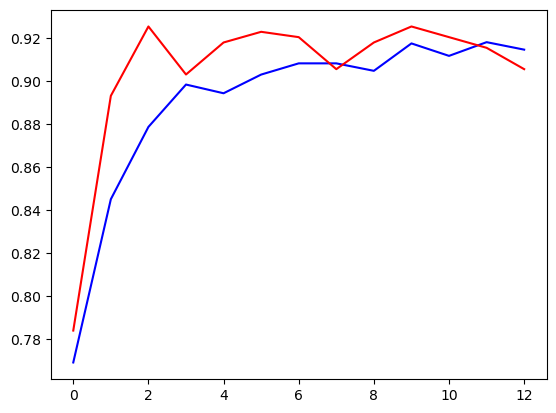

In [99]:
plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='red')

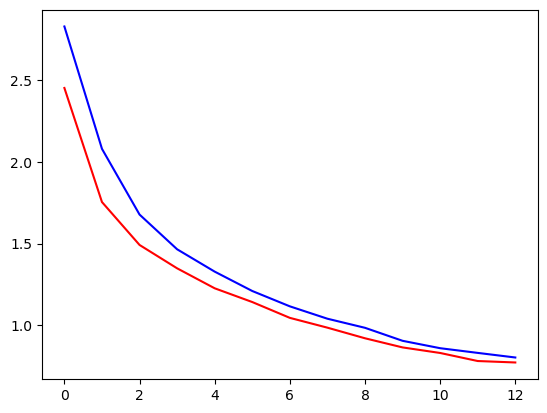

In [100]:
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='red')

In [77]:
import cv2

In [101]:
img=cv2.imread(r"C:\Users\sahub\Desktop\Folders\cnn\dogvscat\dog_catsDataset\train\cats\cat.1151.jpg")
img=cv2.resize(img,(150,150))
img=img/255.0
img=np.expand_dims(img,axis=0)
prediction='Dog' if model.predict(img)>0.5 else 'Cat'
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


'Cat'

In [102]:
img=cv2.imread(r"C:\Users\sahub\Desktop\Folders\cnn\dogvscat\dog_catsDataset\train\dogs\dog.278.jpg")
img=cv2.resize(img,(150,150))
img=img/255.0
img=np.expand_dims(img,axis=0)
prediction='Dog' if model.predict(img)>0.5 else 'Cat'
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step


'Dog'

In [103]:
import pickle
with open('classfier_model','wb') as file:
    pickle.dump(model, file)